In [1]:
from utils.dataloader import DataPartitions, DataGenerator
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

In [107]:
plotsize = 15

# sequences: array(
#   (x:Array, y:Dictionary)
# )
#
partitions = DataPartitions(
    past_frames=6,
    future_frames=4,
    root="../datasets/arda/04_21_full/",
    partial=0.4
)

In [3]:
dataset = DataGenerator(
    root="../datasets/arda/04_21_full/", 
    dataset_partitions=partitions.get_partitions(),
    past_frames=partitions.past_frames, 
    future_frames=partitions.future_frames,
    input_dim=(partitions.past_frames, 256, 256, 3),
    output_dim=(partitions.future_frames, 256, 256, 2),
    batch_size=4,
    n_channels=1,
    buffer_size=1e3,
    buffer_memory=100,
    downsampling=False,
)

In [4]:
X = dataset.get_X()
Y = dataset.get_Y()

X[X > 10e5] = 0 
Y[Y > 10e5] = 0


100%|██████████| 72/72 [01:22<00:00,  1.15s/it]


In [18]:
def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

X, Y = unison_shuffled_copies(X, Y)

0.7520257216165669


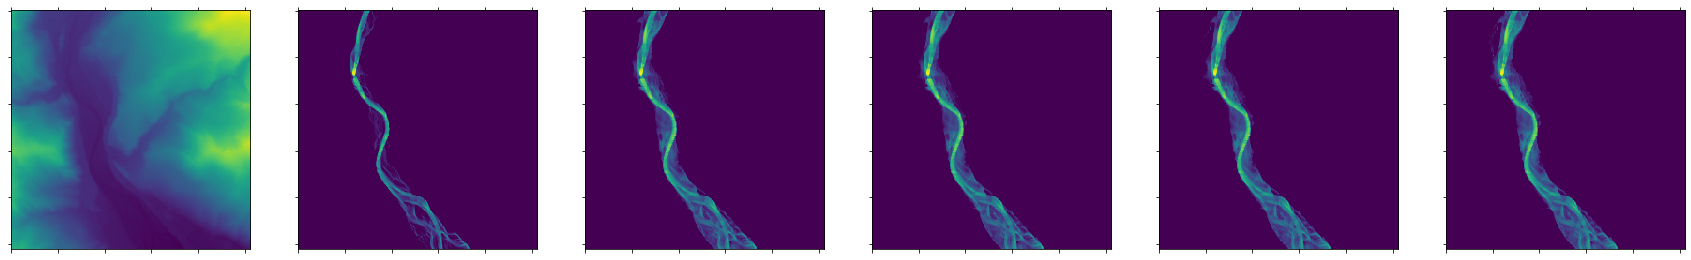

In [47]:
print(dataset.buffer_hit_ratio)

i = 3
j = 5

# Create four polar axes and access them through the returned array
fig, axs = plt.subplots(1, 2 + Y.shape[2], figsize=(plotsize,plotsize))

for ax in axs:
    ax.set_yticklabels([])
    ax.set_xticklabels([])

axs[0].matshow(X[j, i, 0, :, :, 2])
axs[1].matshow(X[j, i, 0, :, :, 0])

for i,frame in enumerate(Y[j,i]):
    axs[i+2].matshow(frame[:, :, 0])


In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [20]:
print("DEP min: {}\nVEL min: {}\nBTM min: {}".format(
    np.min(X_train[:, :, :, :, :, 0]),
    np.min(X_train[:, :, :, :, :, 1]),
    np.min(X_train[:, :, :, :, :, 2])
))

print("DEP max: {}\nVEL max: {}\nBTM max: {}".format(
    np.max(X_train[:, :, :, :, :, 0]),
    np.max(X_train[:, :, :, :, :, 1]),
    np.max(X_train[:, :, :, :, :, 2])
))

DEP min: 0.0
VEL min: 0.0
BTM min: 0.0
DEP max: 3.89991
VEL max: 6.622684388569336
BTM max: 166.27399999999997


### Model

In [21]:
import numpy as np

import torch as th
import torch.nn as nn
import torch.nn.functional as F
from functools import partial

In [22]:
if th.cuda.is_available():  
    dev = "cuda:0" 
else:  
    dev = "cpu"  
device = th.device(dev) 

In [23]:
class ResNetBlock(nn.Module):
        
    def __init__(self, in_filters, filters, stride, kernel_size, padding):
        super(ResNetBlock, self).__init__()
        
        self.activation = nn.ReLU()
        self.c1 = nn.Conv3d(in_filters, filters, kernel_size, stride, padding=padding)
        self.c2 = nn.Conv3d(filters, filters, kernel_size, padding=padding)
        self.c3 = nn.Conv3d(in_filters, filters, (1, 1, 1), stride)
        
        #self.bn = nn.BatchNorm3d(num_features=filters)

    def forward(self, x,):
        
        residual = x
        
        y = self.c1(x)

        #y = self.bn(y)
        y = self.activation(y)
        y = self.c2(y)
        #y = self.bn(y)

        # reshape
        if residual.shape != y.shape:
            residual = self.c3(residual)
            #residual = self.bn(residual)
            
        return self.activation(residual + y)


In [24]:
class Autoencoder(nn.Module):
    
    def __init__(self, channels):
        super(Autoencoder, self).__init__()

        kernel_size = 3
        padding = 1

        self.layers = nn.ModuleList([
            nn.Conv3d(channels, 8, kernel_size=kernel_size, stride=1, padding=padding),
            nn.AvgPool3d((1,2,2)),
            
            ResNetBlock(in_filters = 8, filters = 8, stride = 2, kernel_size=kernel_size, padding=padding),

            nn.Conv3d(8, 16, (1,1,1)),
            ResNetBlock(in_filters = 16, filters = 16, stride = 2, kernel_size=kernel_size, padding=padding),

            nn.Conv3d(16, 32, (1,1,1)),
            ResNetBlock(in_filters = 32, filters = 32, stride = (2,1,1), kernel_size=kernel_size, padding=padding),

            nn.Conv3d(32, 64, (1,1,1)),
            ResNetBlock(in_filters = 64, filters = 64, stride = 1, kernel_size=kernel_size, padding=padding),

            # ----------------------

            nn.ConvTranspose3d(64, 32, (1,2,2), stride=(1,2,2)),
            #nn.BatchNorm3d(num_features=32),

            nn.ConvTranspose3d(32, 16, (2,2,2), stride=(2,2,2)),
            #nn.BatchNorm3d(num_features=16),

            nn.ConvTranspose3d(16, 8, (2,2,2), stride=(2,2,2)),
            #nn.BatchNorm3d(num_features=8),

            nn.ConvTranspose3d(8, 8, (1,1,1), stride=(1,1,1)),
            #nn.BatchNorm3d(num_features=8),
            
            nn.ConvTranspose3d(8, 2, (1,1,1), stride=(1,1,1)),
        ])
    
    def forward(self, x, summary = False):
        
        if summary:
            print("==== Model Summary ====")
            print("{:<15s}{:>4s}".format("Block", "Output shape"))

        for i, l in enumerate(self.layers):
            x = l(x)
            
            if summary:
                print("{:<20s}{:>4s}".format(
                    str(l).split("(")[0],
                    str(x.shape).split("[")[1].split("]")[0]
                ))
        
        return x

In [25]:
def xavier_weights(m):
    if isinstance(m, nn.Conv3d) or isinstance(m, nn.ConvTranspose3d):
        th.nn.init.xavier_uniform(m.weight.data)

def sqrt_weights(m):
    # https://stackoverflow.com/questions/49433936/how-to-initialize-weights-in-pytorch
    if isinstance(m, nn.Conv3d) or isinstance(m, nn.ConvTranspose3d):
        n = m.in_features
        y = 1.0/np.sqrt(n)
        m.weight.data.uniform_(-y, y)
        m.bias.data.fill_(0)

In [26]:
net = Autoencoder(channels=3).to(device)
net(th.Tensor(np.random.random((16, 3, 6, 128, 128))).to(device), True).shape

==== Model Summary ====
Block          Output shape
Conv3d              16, 8, 6, 128, 128
AvgPool3d           16, 8, 6, 64, 64
ResNetBlock         16, 8, 3, 32, 32
Conv3d              16, 16, 3, 32, 32
ResNetBlock         16, 16, 2, 16, 16
Conv3d              16, 32, 2, 16, 16
ResNetBlock         16, 32, 1, 16, 16
Conv3d              16, 64, 1, 16, 16
ResNetBlock         16, 64, 1, 16, 16
ConvTranspose3d     16, 32, 1, 32, 32
ConvTranspose3d     16, 16, 2, 64, 64
ConvTranspose3d     16, 8, 4, 128, 128
ConvTranspose3d     16, 8, 4, 128, 128
ConvTranspose3d     16, 2, 4, 128, 128


torch.Size([16, 2, 4, 128, 128])

In [27]:
import torch.optim as optim

criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=1e-3)

In [28]:
X_train = th.Tensor(X_train).to(device)
y_train = th.Tensor(y_train).to(device)

In [31]:
X_train = X_train.permute(0, 1, 5, 2, 3, 4)
y_train = y_train.permute(0, 1, 5, 2, 3, 4)

In [29]:
X_test = th.Tensor(X_test).to(device)
y_test = th.Tensor(y_test).to(device)

In [30]:
X_test = X_test.permute(0, 1, 5, 2, 3, 4)
y_test = y_test.permute(0, 1, 5, 2, 3, 4)

In [32]:
import pytorch_ssim
from torch.autograd import Variable

def reverse_ssim(y, y_true):

    tot_ssim = 0
    for i, y_pred in enumerate(y):
        y_h_pred = Variable(y_pred)
        y_h_true = Variable(y_true[0][i])

        if th.cuda.is_available():
            y_h_pred = y_h_pred.cuda()
            y_h_true = y_h_true.cuda()

        tot_ssim += pytorch_ssim.ssim(y_h_pred, y_h_true)

    return 1/(tot_ssim/len(y))

In [33]:
losses = []
errors = []
test_errors = []

[0,     9] train_err: 0.000 	  test_err: 0.000 	 avg_loss: 0.158


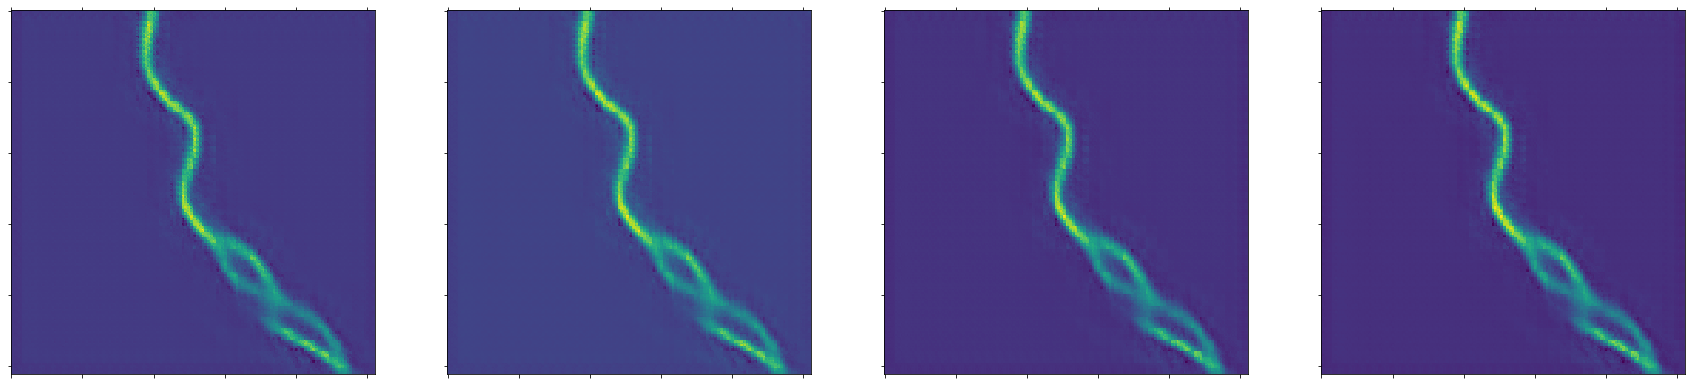

[1,     3] train_err: 0.000 	  test_err: 0.000 	 avg_loss: 0.146
[2,     2] train_err: 0.000 	  test_err: 0.000 	 avg_loss: 0.137
[3,    13] train_err: 0.000 	  test_err: 0.000 	 avg_loss: 0.128


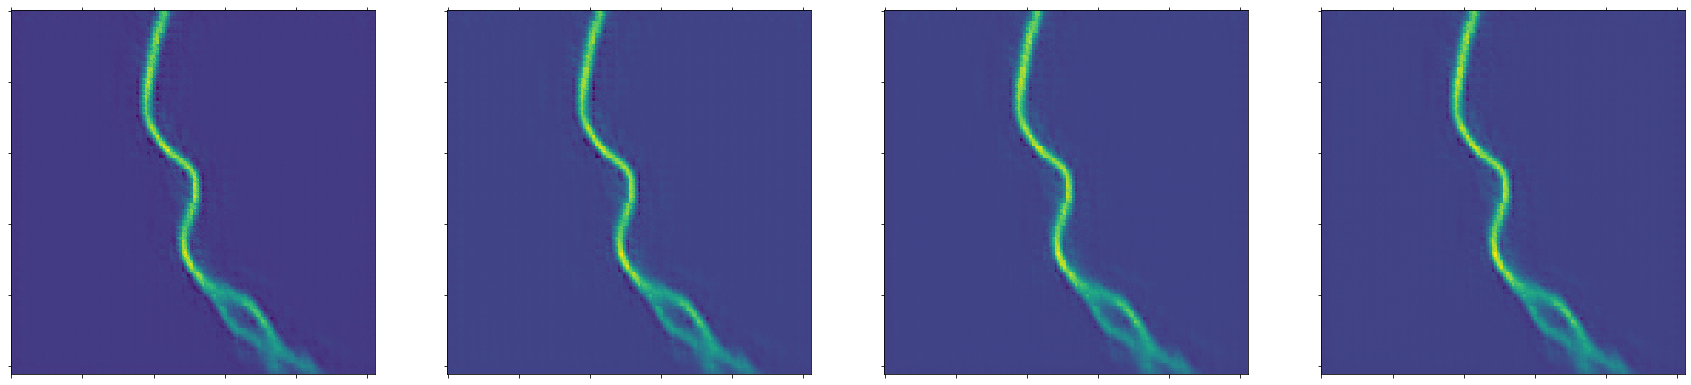

[4,    10] train_err: 0.000 	  test_err: 0.000 	 avg_loss: 0.121
[5,    10] train_err: 0.000 	  test_err: 0.000 	 avg_loss: 0.115
[6,    10] train_err: 0.000 	  test_err: 0.000 	 avg_loss: 0.110


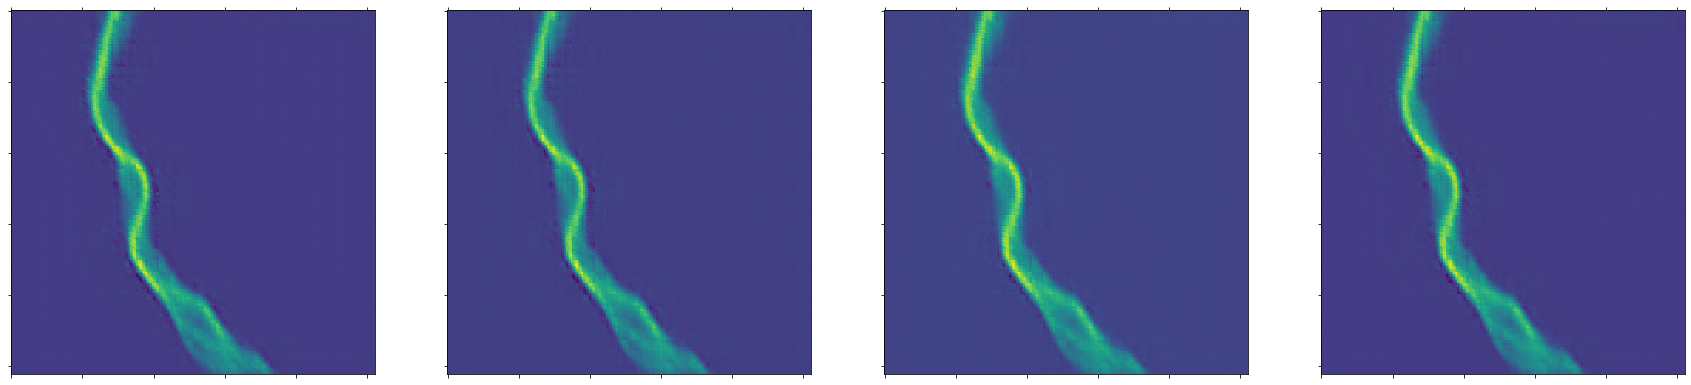

[7,     2] train_err: 0.000 	  test_err: 0.000 	 avg_loss: 0.105
[8,    12] train_err: 0.000 	  test_err: 0.000 	 avg_loss: 0.101
[9,     1] train_err: 0.000 	  test_err: 0.000 	 avg_loss: 0.098


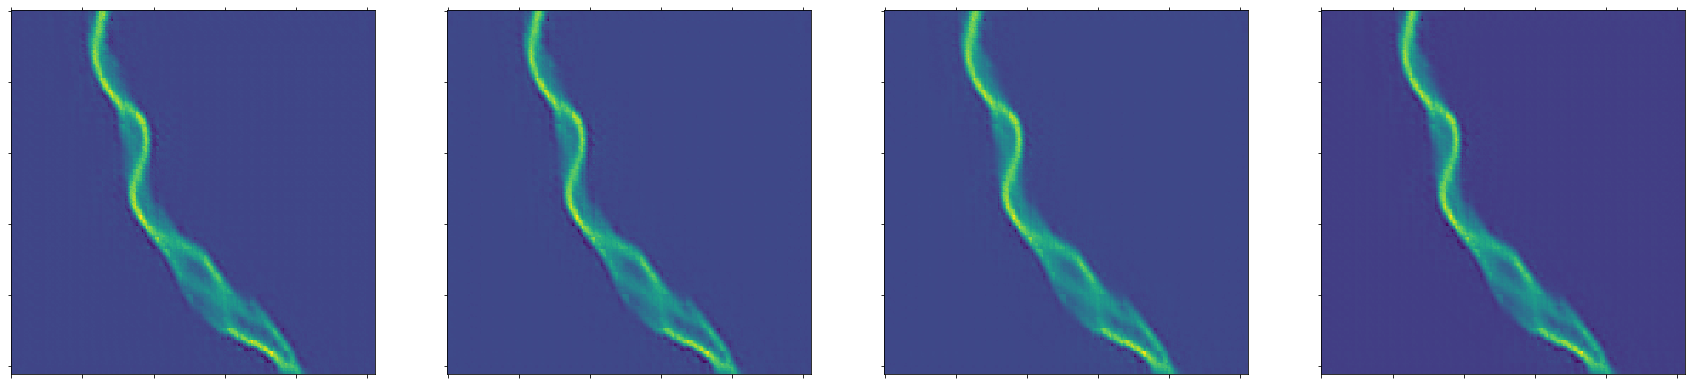

[10,     8] train_err: 0.000 	  test_err: 0.000 	 avg_loss: 0.094
[11,     3] train_err: 0.000 	  test_err: 0.000 	 avg_loss: 0.091
[12,     7] train_err: 0.000 	  test_err: 0.000 	 avg_loss: 0.088


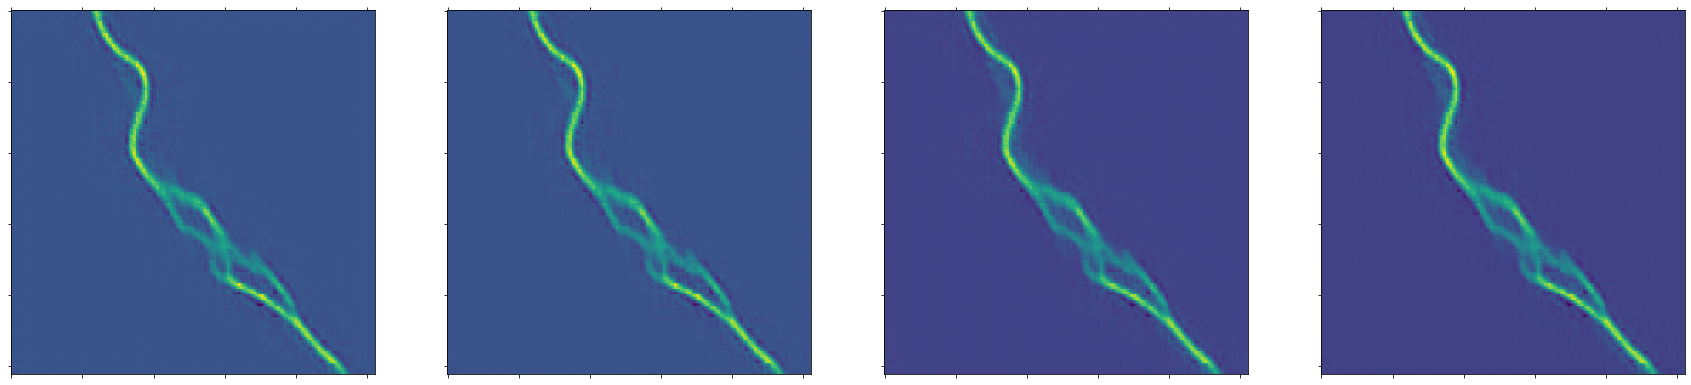

[13,    12] train_err: 0.000 	  test_err: 0.000 	 avg_loss: 0.086
[14,     8] train_err: 0.000 	  test_err: 0.000 	 avg_loss: 0.083
[15,     8] train_err: 0.000 	  test_err: 0.000 	 avg_loss: 0.081


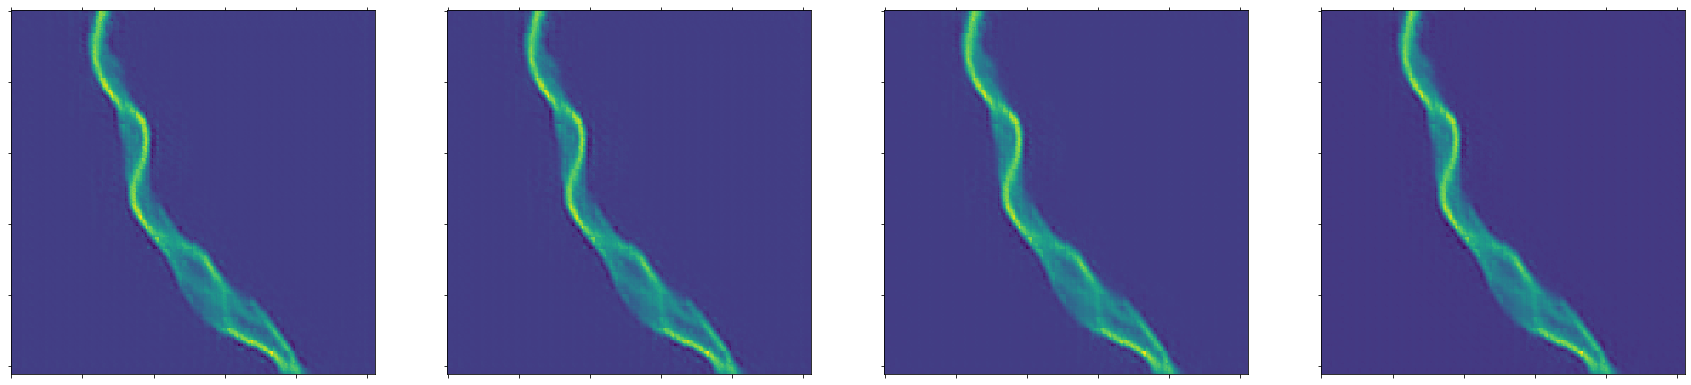

[16,     1] train_err: 0.000 	  test_err: 0.000 	 avg_loss: 0.079
[17,    13] train_err: 0.000 	  test_err: 0.000 	 avg_loss: 0.077
[18,     8] train_err: 0.000 	  test_err: 0.000 	 avg_loss: 0.075


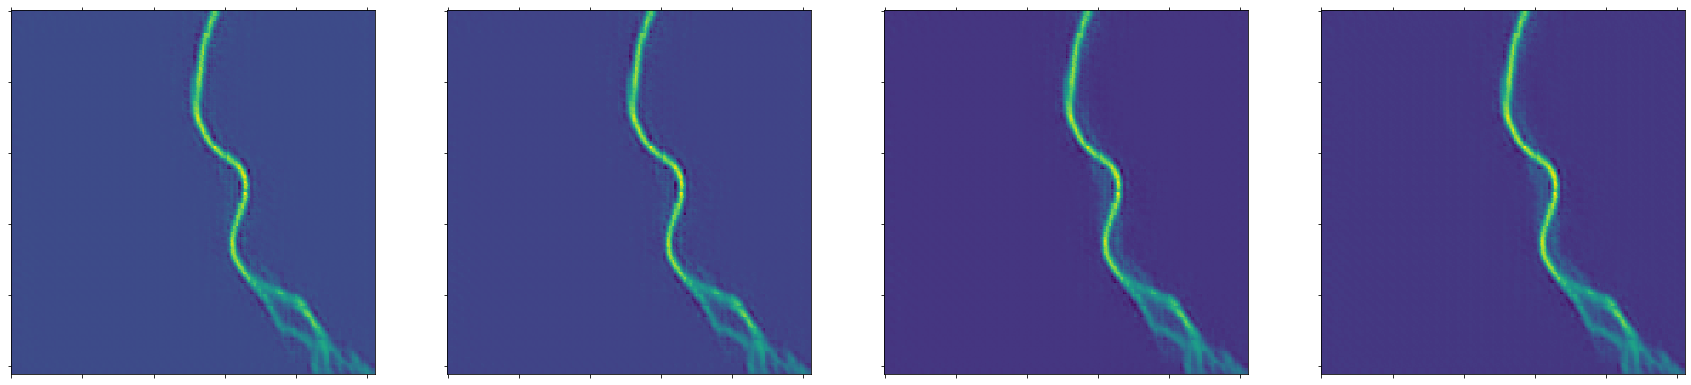

[19,     9] train_err: 0.000 	  test_err: 0.000 	 avg_loss: 0.074
[20,     9] train_err: 0.000 	  test_err: 0.000 	 avg_loss: 0.072
[21,    14] train_err: 0.000 	  test_err: 0.000 	 avg_loss: 0.071


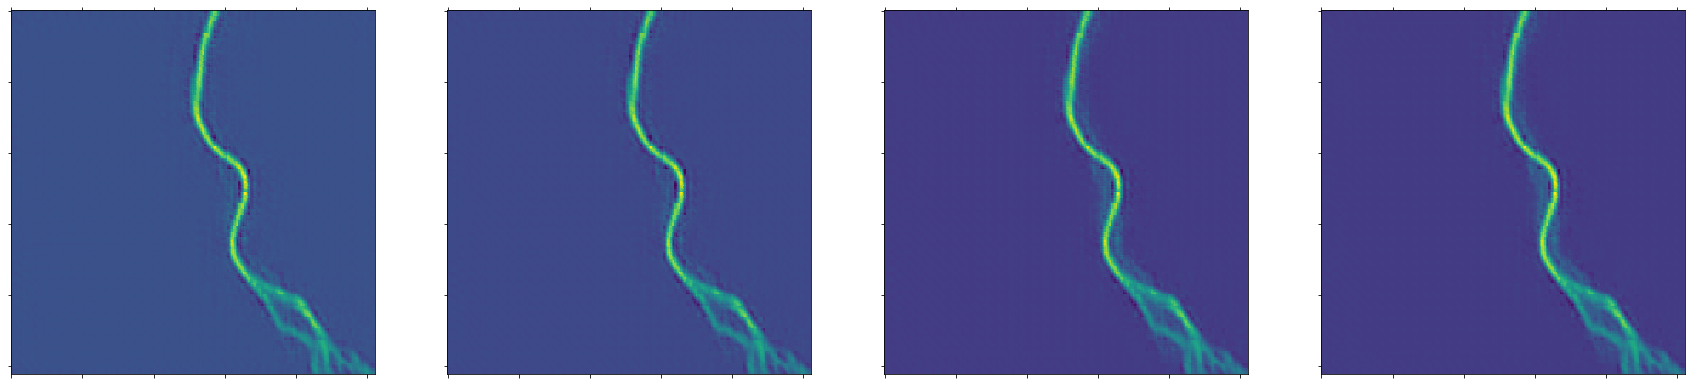

[22,    12] train_err: 0.000 	  test_err: 0.000 	 avg_loss: 0.069
[23,     3] train_err: 0.000 	  test_err: 0.000 	 avg_loss: 0.068
[24,     9] train_err: 0.000 	  test_err: 0.000 	 avg_loss: 0.067


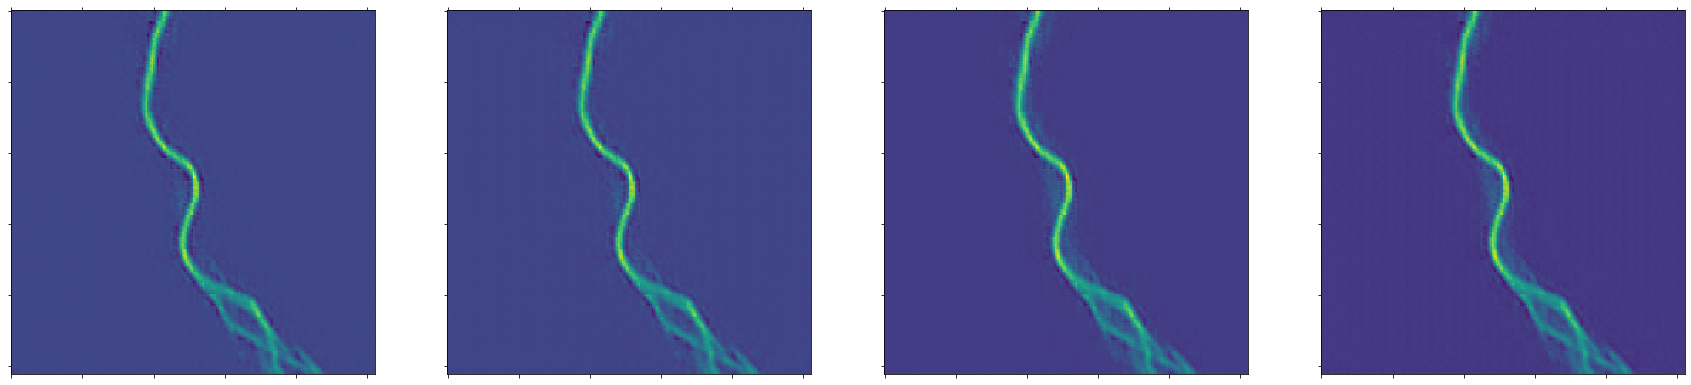

[25,    10] train_err: 0.000 	  test_err: 0.000 	 avg_loss: 0.066
[26,    13] train_err: 0.000 	  test_err: 0.000 	 avg_loss: 0.065
[27,     4] train_err: 0.000 	  test_err: 0.000 	 avg_loss: 0.063


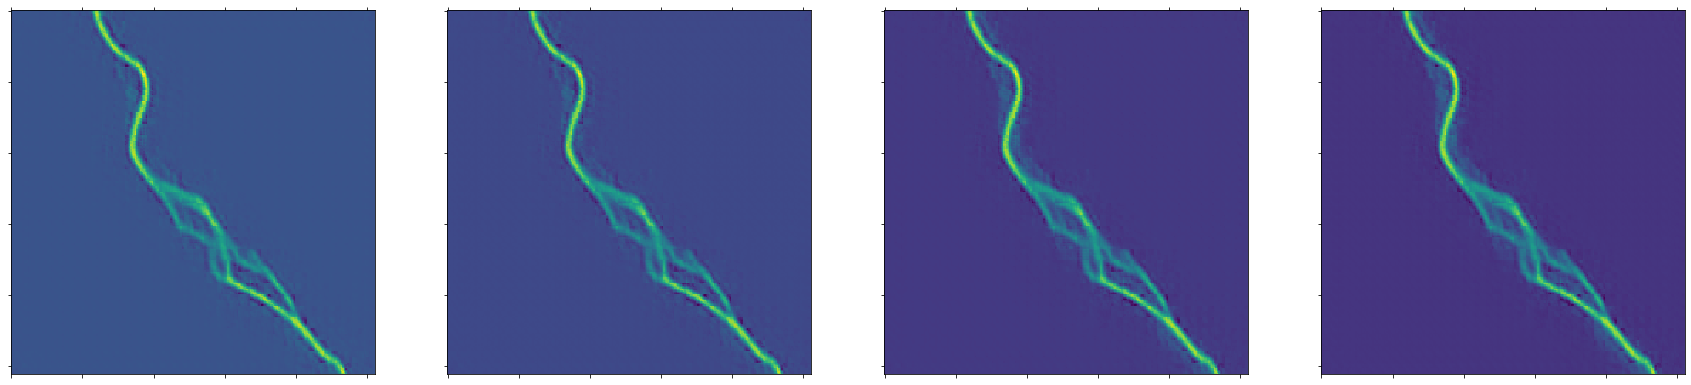

[28,     8] train_err: 0.000 	  test_err: 0.000 	 avg_loss: 0.062
[29,     0] train_err: 0.000 	  test_err: 0.000 	 avg_loss: 0.061
[30,     0] train_err: 0.000 	  test_err: 0.000 	 avg_loss: 0.061


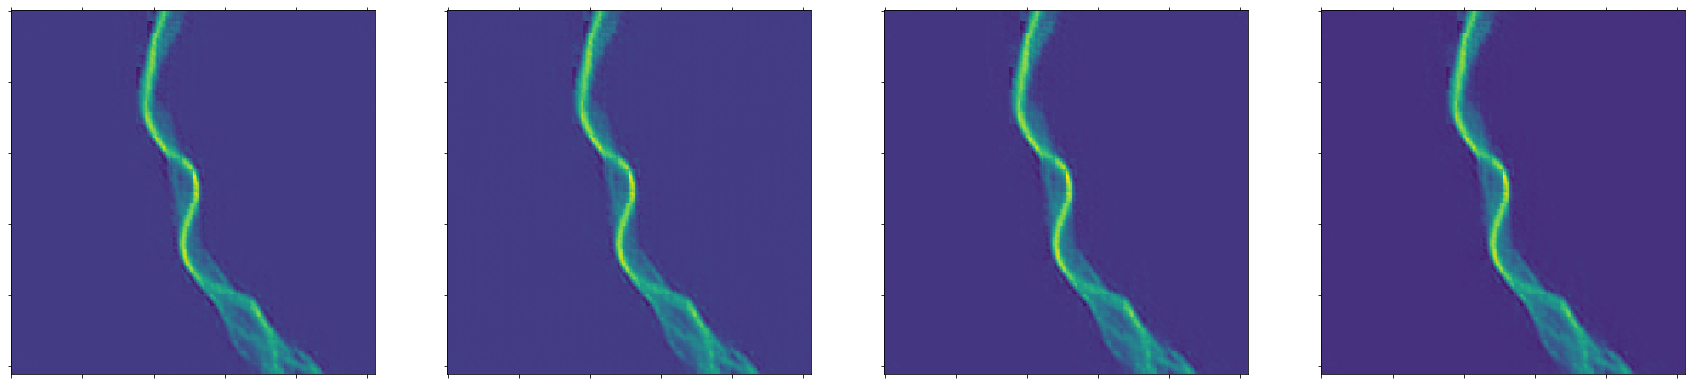

[31,     8] train_err: 0.000 	  test_err: 0.000 	 avg_loss: 0.060
[32,    14] train_err: 0.000 	  test_err: 0.000 	 avg_loss: 0.059
[33,    13] train_err: 0.000 	  test_err: 0.000 	 avg_loss: 0.058


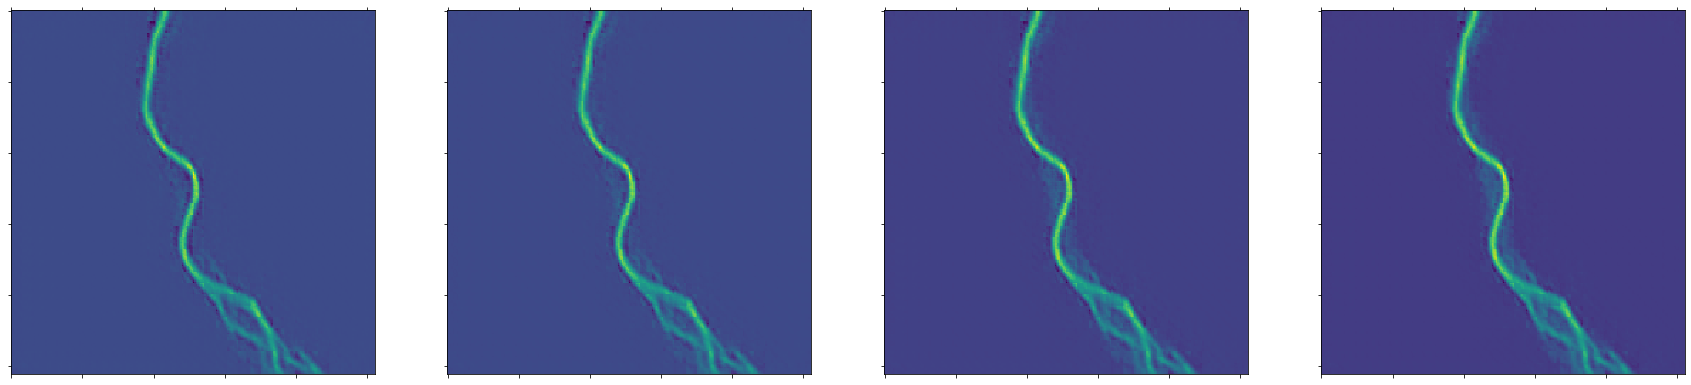

[34,     9] train_err: 0.000 	  test_err: 0.000 	 avg_loss: 0.057
[35,    11] train_err: 0.000 	  test_err: 0.000 	 avg_loss: 0.057
[36,    12] train_err: 0.000 	  test_err: 0.000 	 avg_loss: 0.056


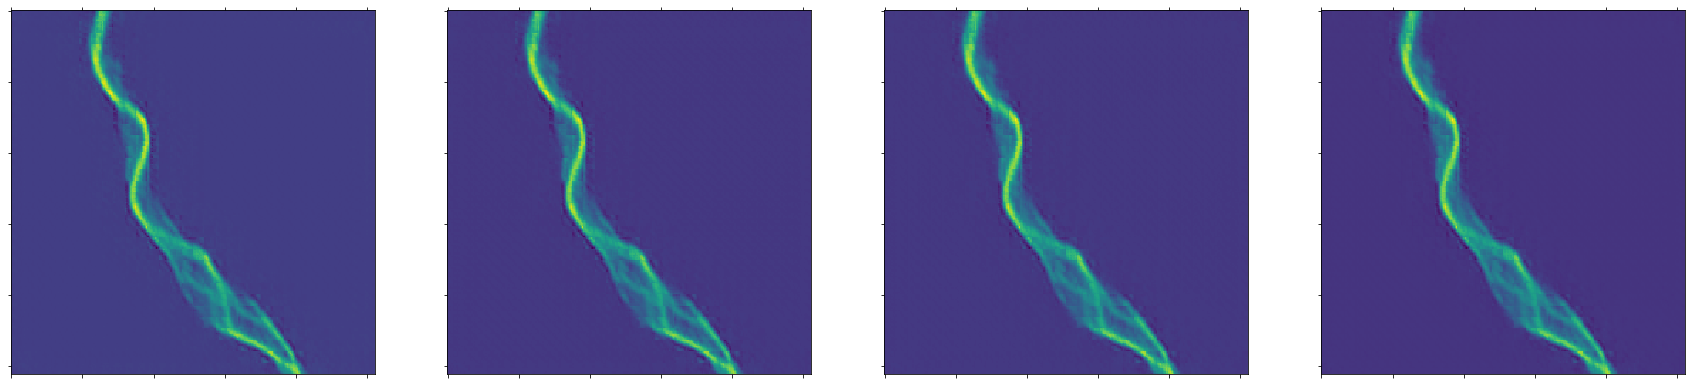

[37,     6] train_err: 0.000 	  test_err: 0.000 	 avg_loss: 0.055
[38,     1] train_err: 0.000 	  test_err: 0.000 	 avg_loss: 0.054
[39,     4] train_err: 0.000 	  test_err: 0.000 	 avg_loss: 0.054


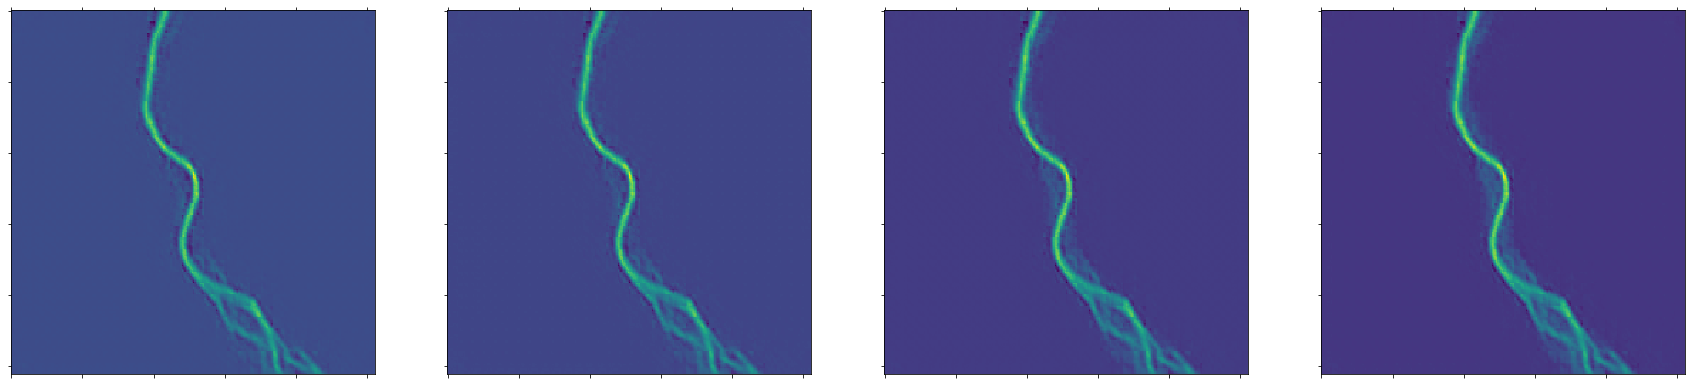

[40,     4] train_err: 0.000 	  test_err: 0.000 	 avg_loss: 0.053
[41,     3] train_err: 0.000 	  test_err: 0.000 	 avg_loss: 0.053
[42,    10] train_err: 0.000 	  test_err: 0.000 	 avg_loss: 0.052


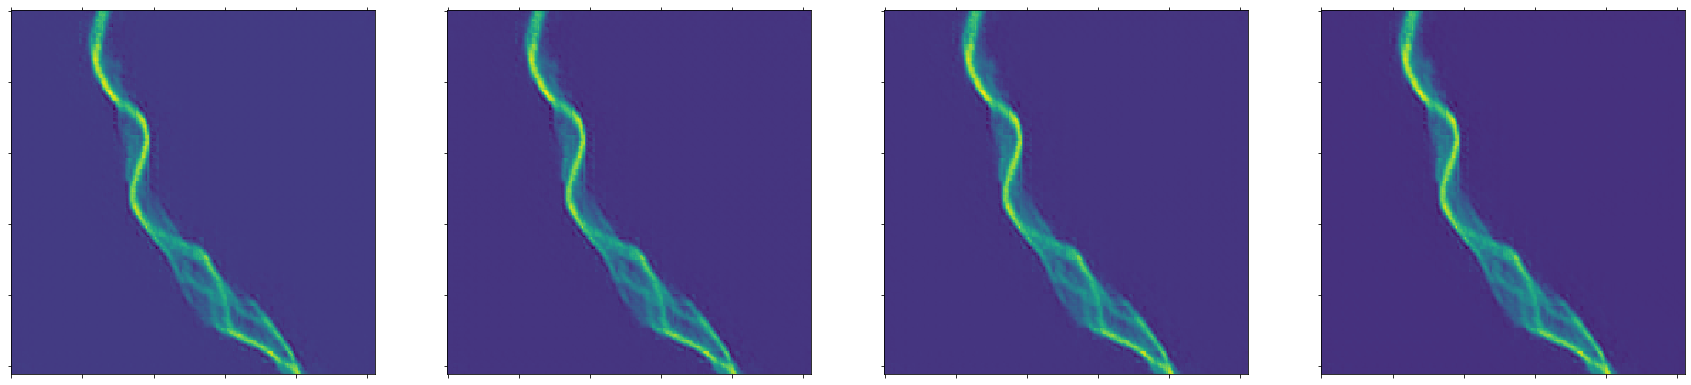

[43,    14] train_err: 0.000 	  test_err: 0.000 	 avg_loss: 0.051
[44,     9] train_err: 0.000 	  test_err: 0.000 	 avg_loss: 0.051
[45,     7] train_err: 0.000 	  test_err: 0.000 	 avg_loss: 0.050


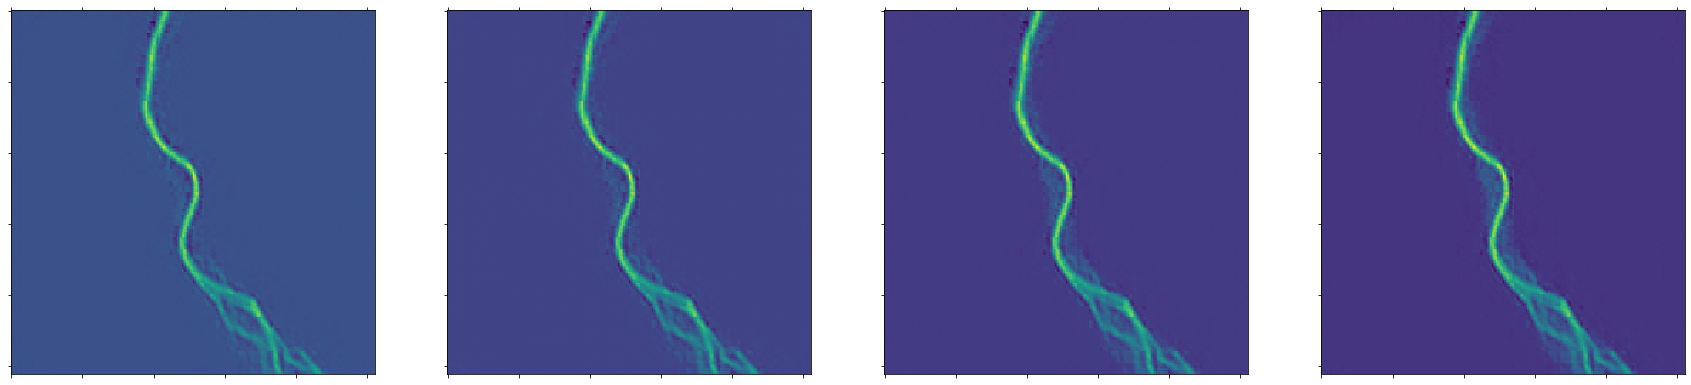

[46,    10] train_err: 0.000 	  test_err: 0.000 	 avg_loss: 0.050
[47,     6] train_err: 0.000 	  test_err: 0.000 	 avg_loss: 0.049
[48,     6] train_err: 0.000 	  test_err: 0.000 	 avg_loss: 0.049


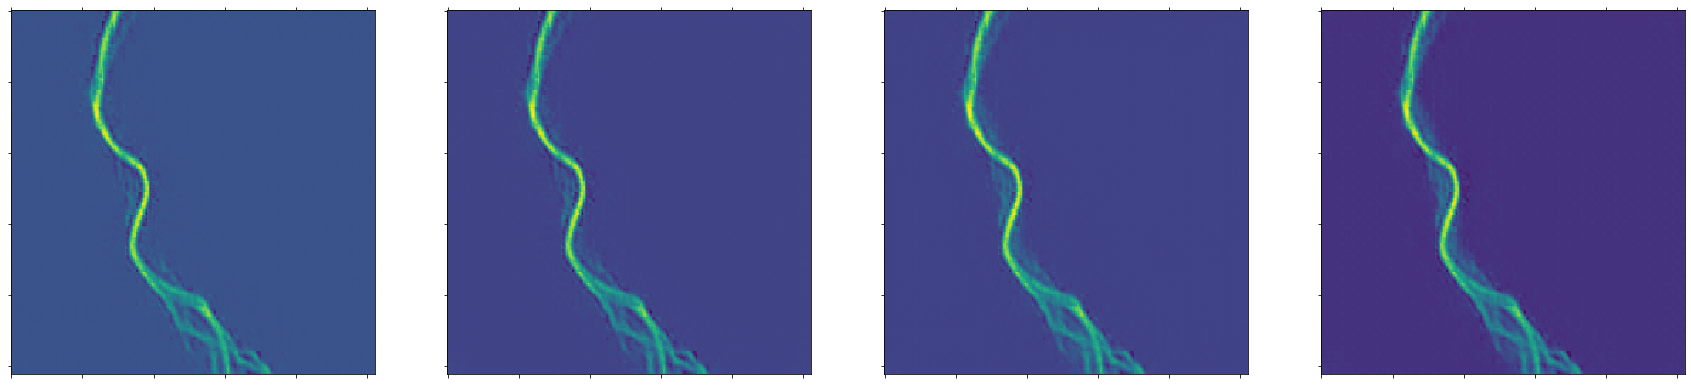

[49,     7] train_err: 0.000 	  test_err: 0.000 	 avg_loss: 0.048
[50,    11] train_err: 0.000 	  test_err: 0.000 	 avg_loss: 0.048
[51,     1] train_err: 0.000 	  test_err: 0.000 	 avg_loss: 0.048


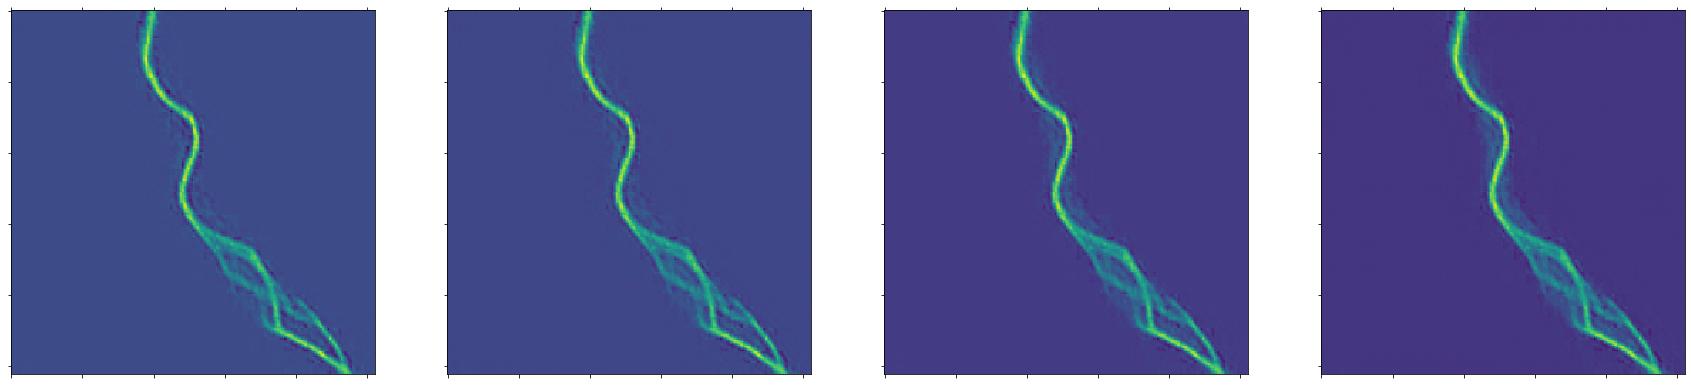

[52,     4] train_err: 0.000 	  test_err: 0.000 	 avg_loss: 0.047
[53,    12] train_err: 0.000 	  test_err: 0.000 	 avg_loss: 0.047
[54,    13] train_err: 0.000 	  test_err: 0.000 	 avg_loss: 0.046


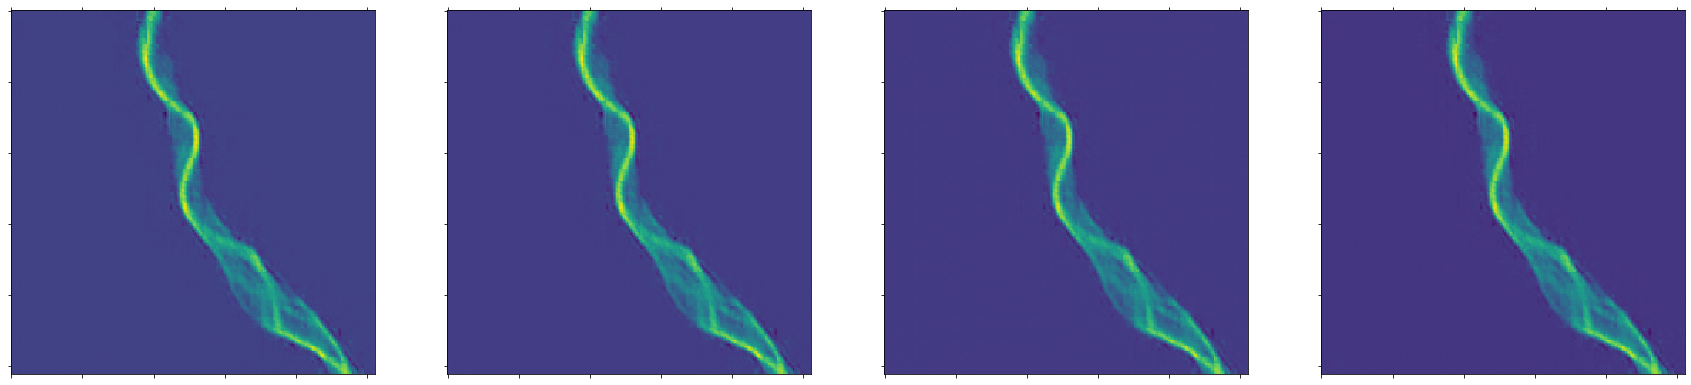

[55,    12] train_err: 0.000 	  test_err: 0.000 	 avg_loss: 0.046
[56,     9] train_err: 0.000 	  test_err: 0.000 	 avg_loss: 0.046
[57,    14] train_err: 0.000 	  test_err: 0.000 	 avg_loss: 0.045


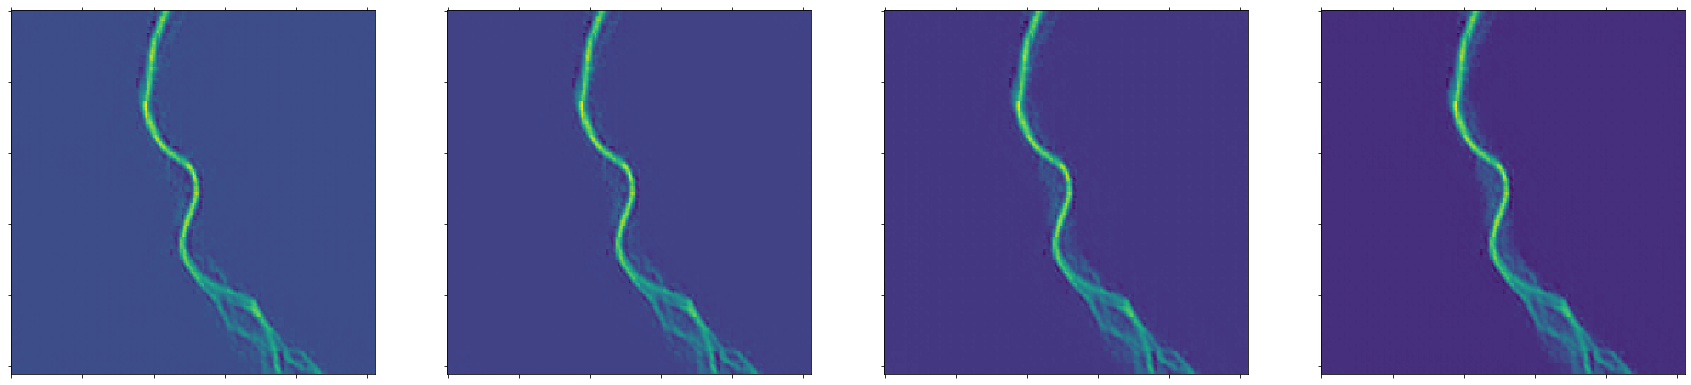

[58,     2] train_err: 0.000 	  test_err: 0.000 	 avg_loss: 0.045
[59,     7] train_err: 0.000 	  test_err: 0.000 	 avg_loss: 0.044
[60,    13] train_err: 0.000 	  test_err: 0.000 	 avg_loss: 0.044


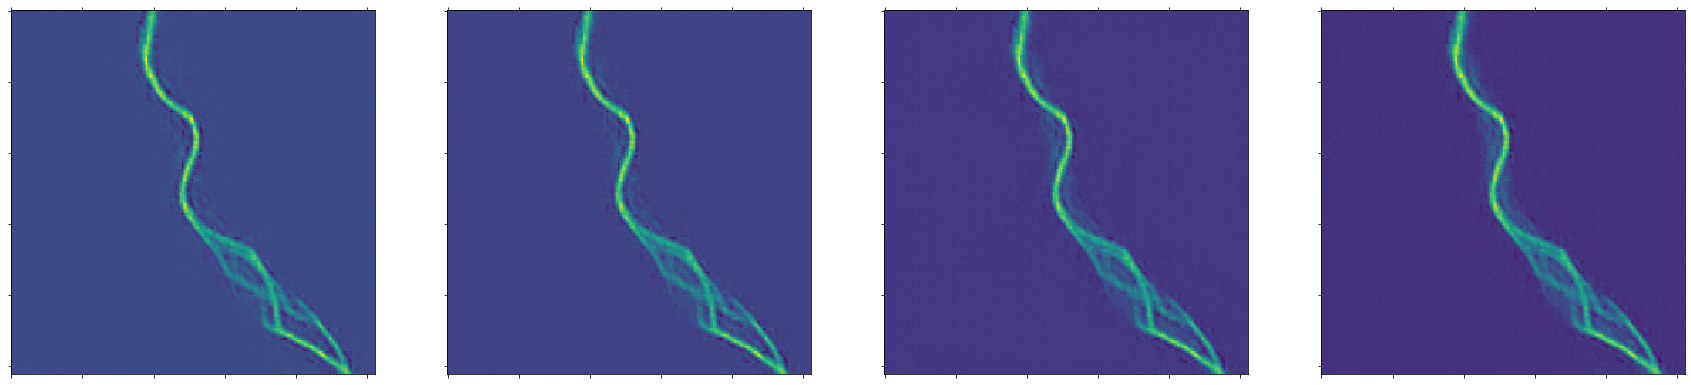

[61,    12] train_err: 0.000 	  test_err: 0.000 	 avg_loss: 0.044
[62,    13] train_err: 0.000 	  test_err: 0.000 	 avg_loss: 0.043
[63,     4] train_err: 0.000 	  test_err: 0.000 	 avg_loss: 0.043


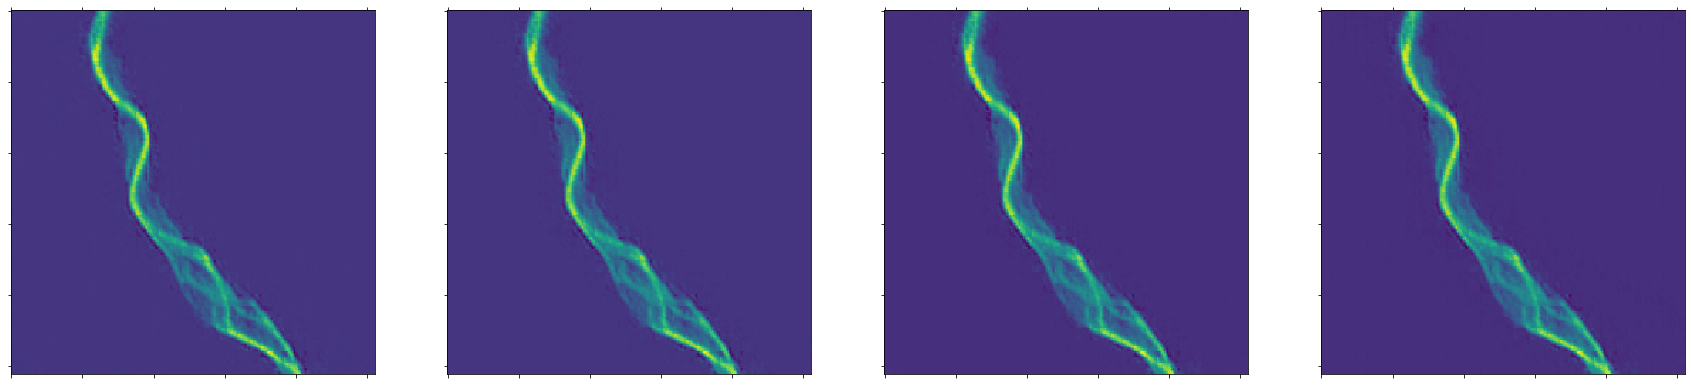

[64,     7] train_err: 0.000 	  test_err: 0.000 	 avg_loss: 0.043
[65,     5] train_err: 0.000 	  test_err: 0.000 	 avg_loss: 0.043
[66,    12] train_err: 0.000 	  test_err: 0.000 	 avg_loss: 0.042


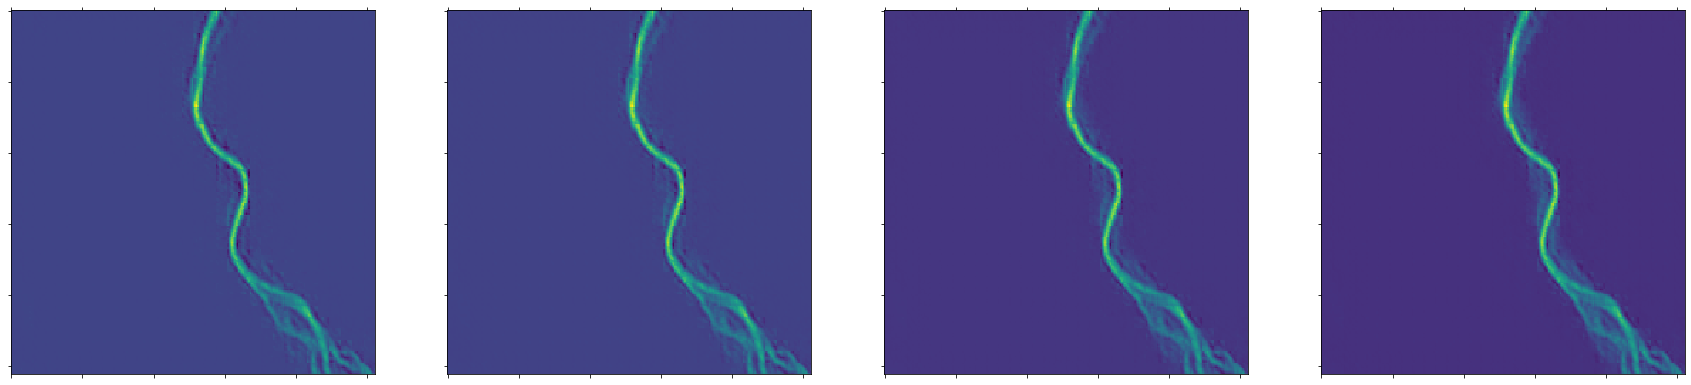

[67,    10] train_err: 0.000 	  test_err: 0.000 	 avg_loss: 0.042
[68,    11] train_err: 0.000 	  test_err: 0.000 	 avg_loss: 0.042
[69,     8] train_err: 0.000 	  test_err: 0.000 	 avg_loss: 0.041


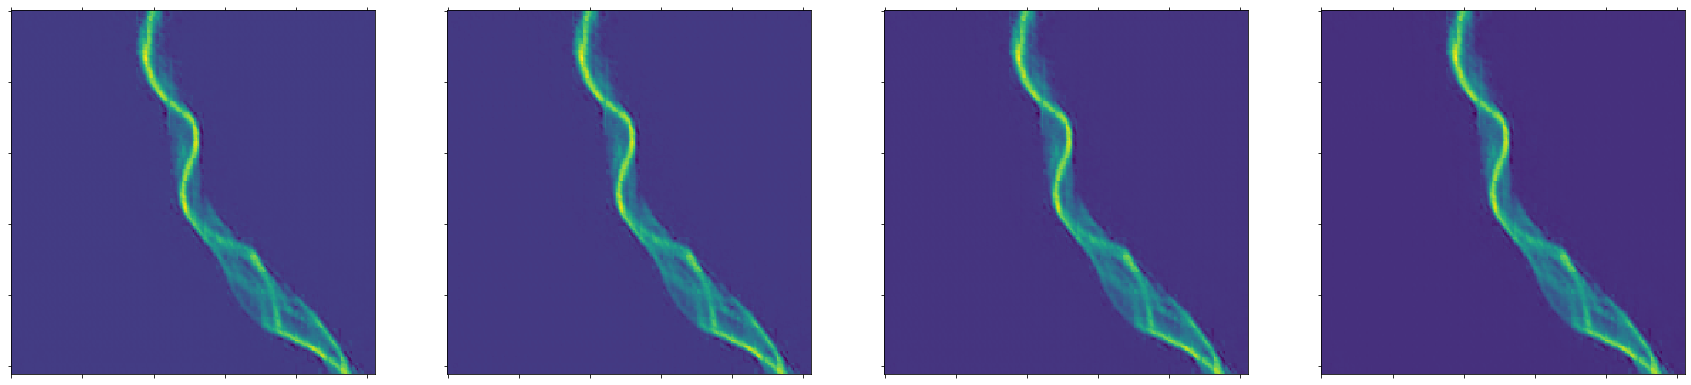

[70,     5] train_err: 0.000 	  test_err: 0.000 	 avg_loss: 0.041
[71,     8] train_err: 0.000 	  test_err: 0.000 	 avg_loss: 0.041
[72,     1] train_err: 0.000 	  test_err: 0.000 	 avg_loss: 0.041


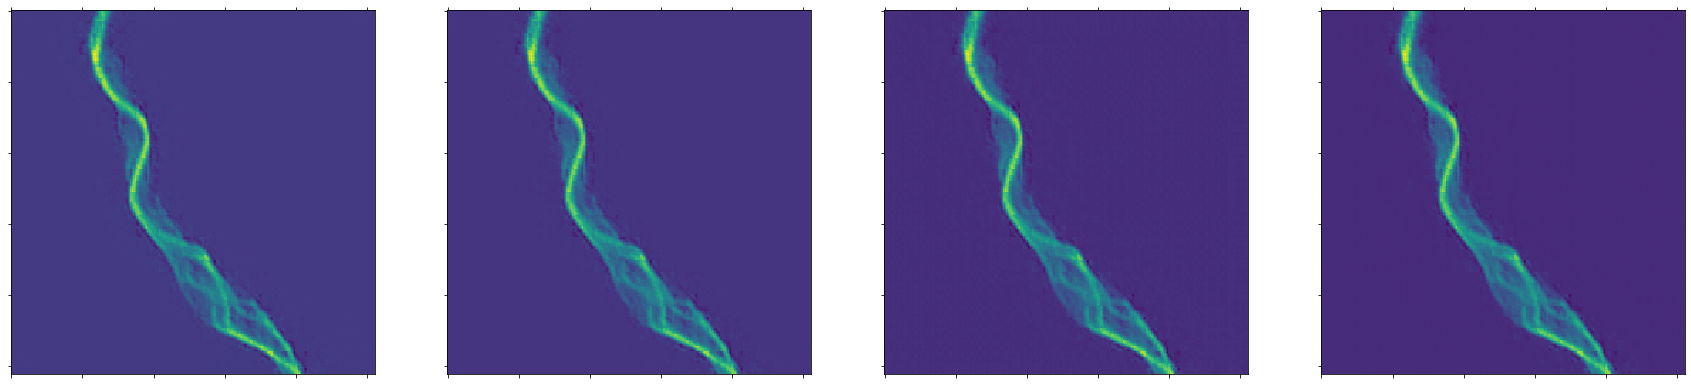

[73,    12] train_err: 0.000 	  test_err: 0.000 	 avg_loss: 0.040
[74,    14] train_err: 0.000 	  test_err: 0.000 	 avg_loss: 0.040
[75,    13] train_err: 0.000 	  test_err: 0.000 	 avg_loss: 0.040


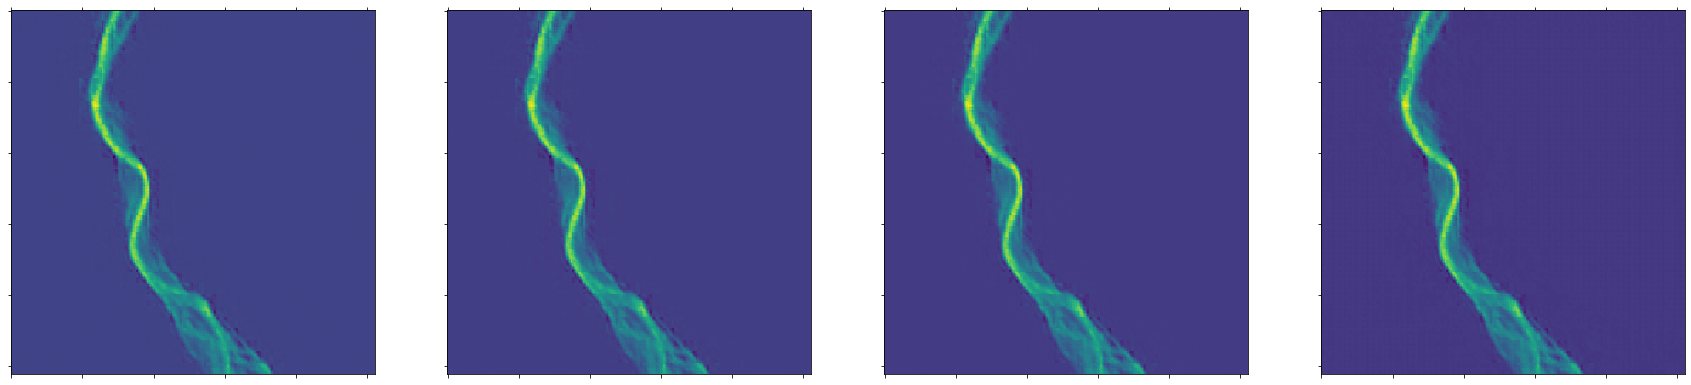

[76,     3] train_err: 0.000 	  test_err: 0.000 	 avg_loss: 0.040
[77,    14] train_err: 0.000 	  test_err: 0.000 	 avg_loss: 0.039
[78,     2] train_err: 0.000 	  test_err: 0.000 	 avg_loss: 0.039


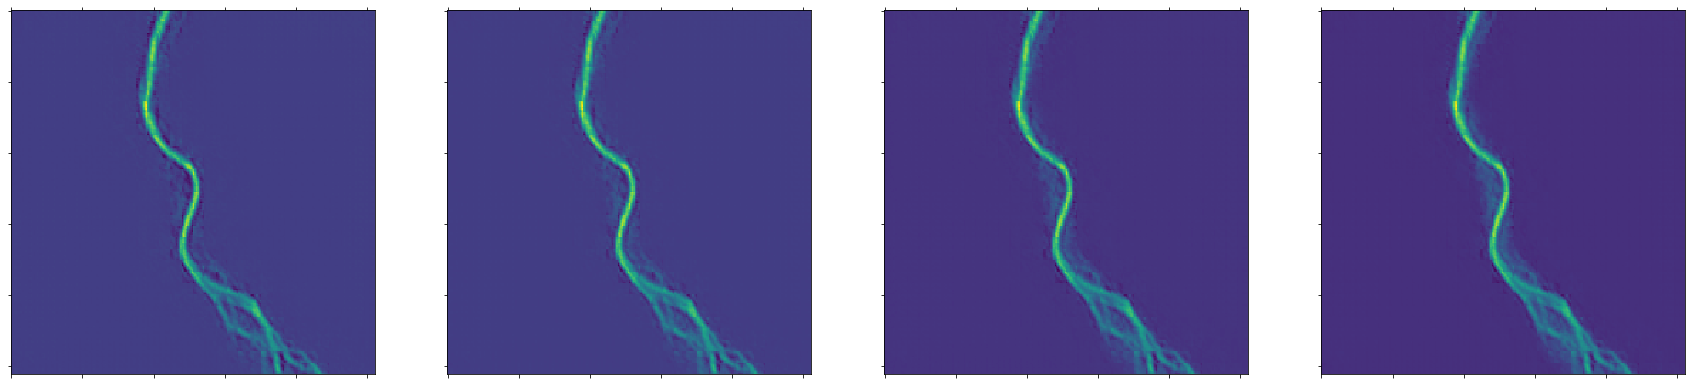

[79,     1] train_err: 0.000 	  test_err: 0.000 	 avg_loss: 0.039
[80,     5] train_err: 0.000 	  test_err: 0.000 	 avg_loss: 0.039
[81,    14] train_err: 0.000 	  test_err: 0.000 	 avg_loss: 0.039


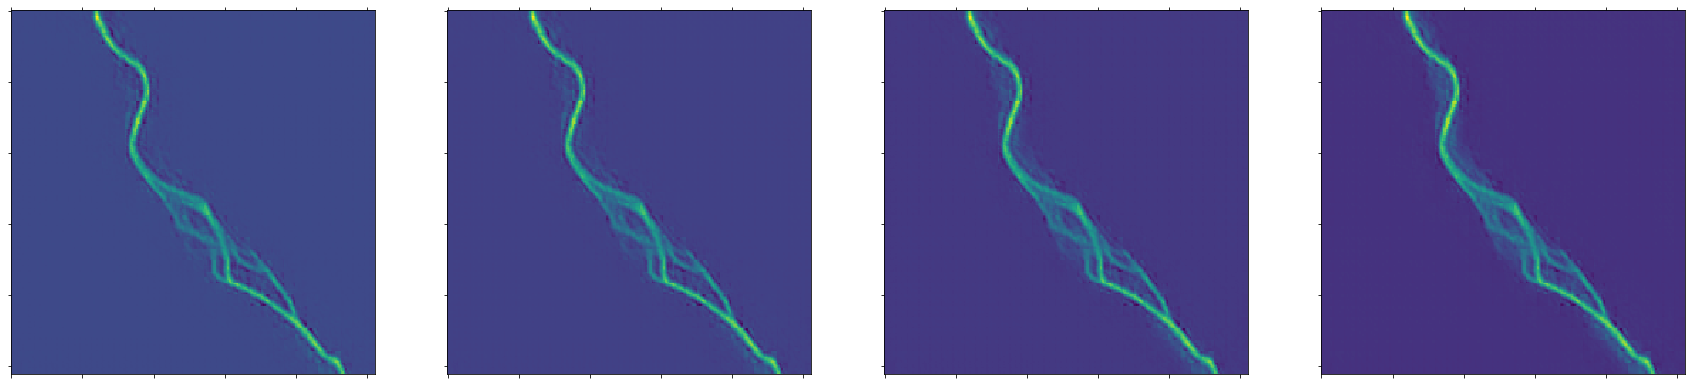

[82,     1] train_err: 0.000 	  test_err: 0.000 	 avg_loss: 0.038
[83,    11] train_err: 0.000 	  test_err: 0.000 	 avg_loss: 0.038
[84,     4] train_err: 0.000 	  test_err: 0.000 	 avg_loss: 0.038


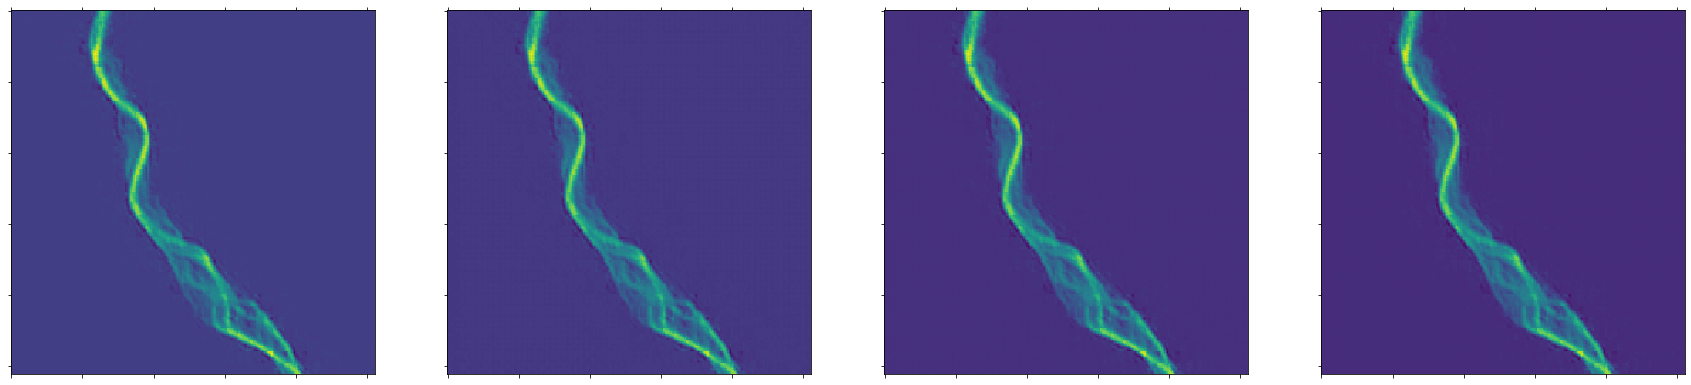

[85,    12] train_err: 0.000 	  test_err: 0.000 	 avg_loss: 0.038
[86,     1] train_err: 0.000 	  test_err: 0.000 	 avg_loss: 0.038
[87,    13] train_err: 0.000 	  test_err: 0.000 	 avg_loss: 0.037


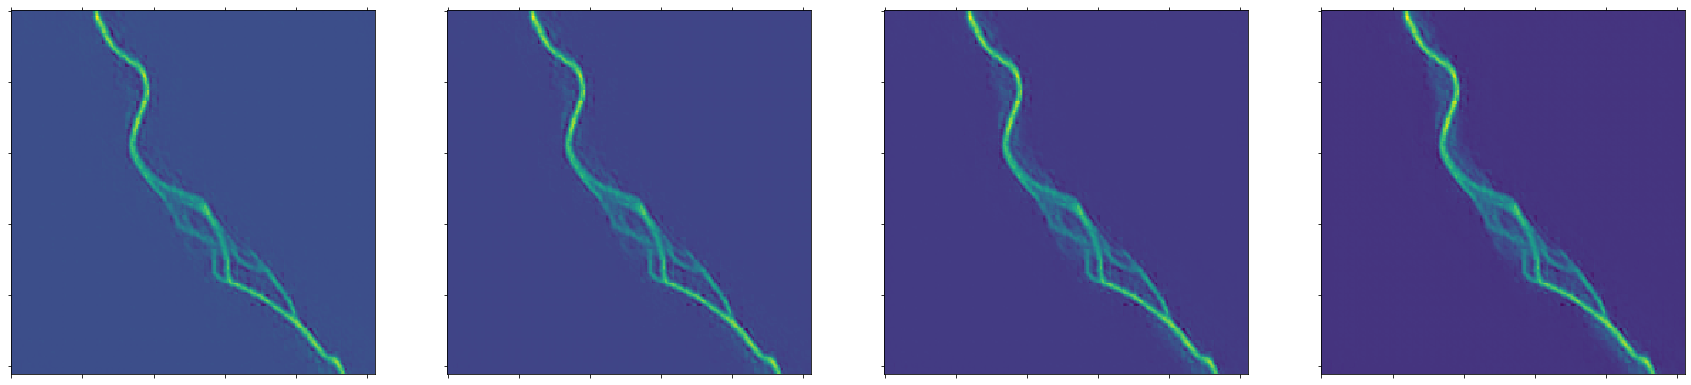

[88,     3] train_err: 0.000 	  test_err: 0.000 	 avg_loss: 0.037
[89,    13] train_err: 0.000 	  test_err: 0.000 	 avg_loss: 0.037
[90,     4] train_err: 0.000 	  test_err: 0.000 	 avg_loss: 0.037


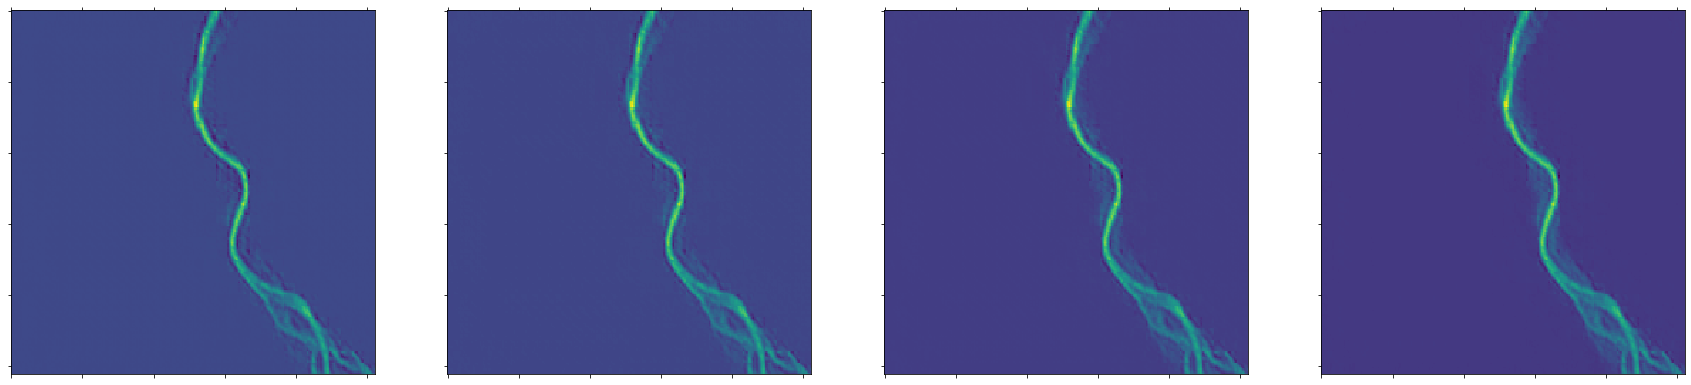

[91,     9] train_err: 0.000 	  test_err: 0.000 	 avg_loss: 0.037
[92,     4] train_err: 0.000 	  test_err: 0.000 	 avg_loss: 0.036
[93,     9] train_err: 0.000 	  test_err: 0.000 	 avg_loss: 0.036


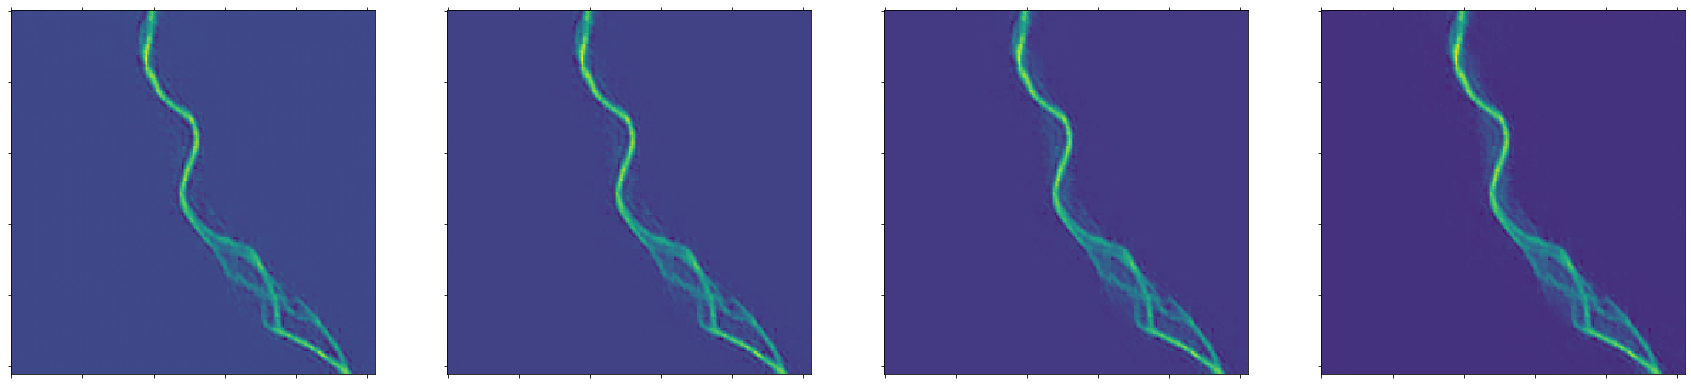

[94,     6] train_err: 0.000 	  test_err: 0.000 	 avg_loss: 0.036
[95,     1] train_err: 0.000 	  test_err: 0.000 	 avg_loss: 0.036


KeyboardInterrupt: 

In [36]:
epochs = 100

for epoch in range(epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, batch in enumerate(X_train):

        optimizer.zero_grad()

        outputs = net(batch)
        
        loss = criterion(outputs, y_train[i])
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        
        losses.append(loss.item())

        # print("batch {} - loss {}".format(i, loss.item()))

        if i == len(X_train)-1:
            # randomly pick a test batch and compute it
            i = np.random.randint(len(y_test), size=1)
            
            train_out = net(X_test[i][0])
            test_out = net(X_train[i][0])
            
            #train_err = reverse_ssim(train_out, y_train[i]).item()
            #test_err = reverse_ssim(test_out, y_test[i]).item()
            train_err = 0
            test_err = 0

            test_errors.append(test_err)
            errors.append(train_err)
            
            print('[%d, %5d] train_err: %.3f \t  test_err: %.3f \t avg_loss: %.3f' %
                  (epoch, i, train_err, test_err, np.mean(losses)))

    if epoch % 3 == 0:
        i = np.random.randint(len(X_test))
        outputs = net(X_test[i])

        #------------------------------
        fig, axs = plt.subplots(1, outputs[0,0].shape[0], figsize=(plotsize,plotsize))

        for ax in axs:
            ax.set_yticklabels([])
            ax.set_xticklabels([])

        for i,frame in enumerate(outputs[0,0]):
            axs[i].matshow(frame.cpu().detach().numpy())

        plt.show()
        #------------------------------

        #if epoch % 10 == 0:
        #    print('[%d, %5d] loss: %.3f' %
        #          (epoch + 1, i + 1, running_loss / 2000))
        #    running_loss = 0.0

print('Finished Training')

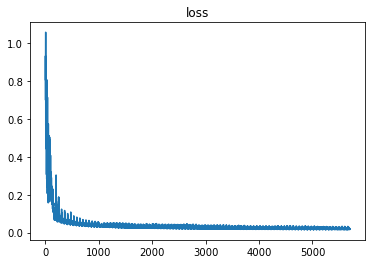

In [23]:
plt.title("loss")
plt.plot(range(len(losses)), losses)
pass

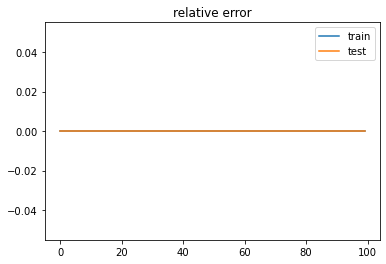

In [24]:
plt.title("relative error")
plt.plot(range(len(errors)), errors, label="train")
plt.plot(range(len(test_errors)), test_errors, label="test")
plt.legend()
pass


In [104]:
import matplotlib as mpl

mpl.rcParams['text.color'] = 'w'


======== Past frames ========


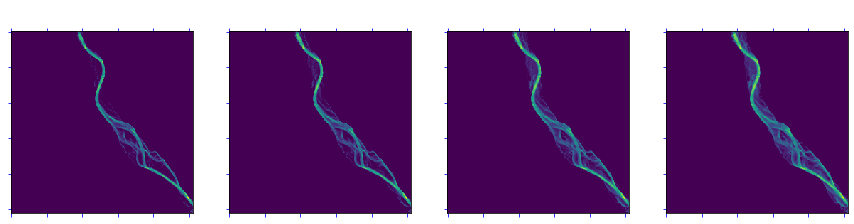

======== True Future vs Predicted frames ========


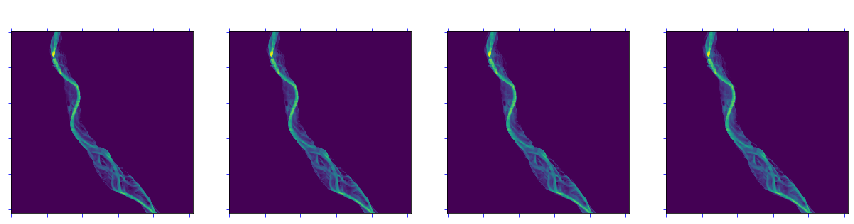

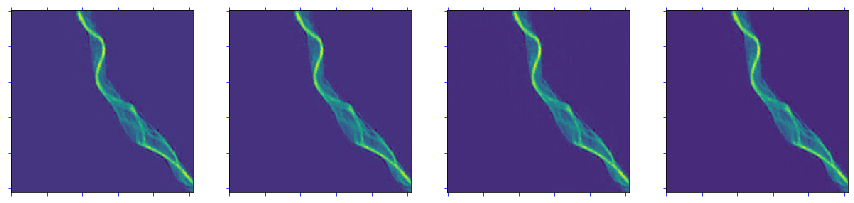

In [108]:
k = np.random.randint(len(X_train))
#k = 5
input = th.unsqueeze(X_train[k,0], 0)
outputs = net(input)

#------------------------------
num_predicted_frames = outputs[0,0].shape[0] # per allineare frames passati e futuri
fig, axs = plt.subplots(1, num_predicted_frames, figsize=(plotsize,plotsize))

for ax in axs:
    ax.set_yticklabels([])
    ax.set_xticklabels([])

for i,frame in enumerate(input[0,0,-num_predicted_frames:]):
    axs[i].matshow(frame.cpu().detach().numpy())
    axs[i].set_title('t = {}'.format(i))

print("======== Past frames ========")
plt.show()

print("======== True Future vs Predicted frames ========")

#------------------------------
fig, axs = plt.subplots(1, num_predicted_frames, figsize=(plotsize,plotsize))

for ax in axs:
    ax.set_yticklabels([])
    ax.set_xticklabels([])

for i,frame in enumerate(y_test[k,0,0]):
    axs[i].matshow(frame.cpu().detach().numpy())
    axs[i].set_title('t = {}'.format(i+num_predicted_frames))

plt.show()
#------------------------------
fig, axs = plt.subplots(1, outputs[0,0].shape[0], figsize=(plotsize,plotsize))

for ax in axs:
    ax.set_yticklabels([])
    ax.set_xticklabels([])

for i,frame in enumerate(outputs[0,0]):
    axs[i].matshow(frame.cpu().detach().numpy())

plt.show()
#------------------------------

======== Past frames ========


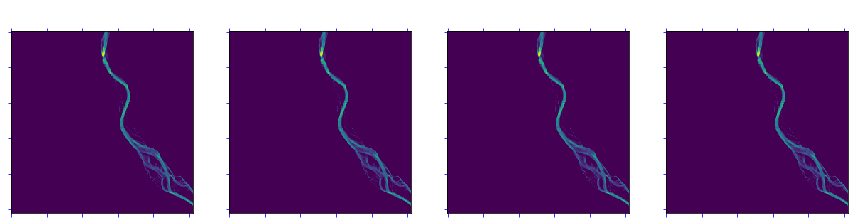

======== True vs Autoregressive Pred Frames  ========


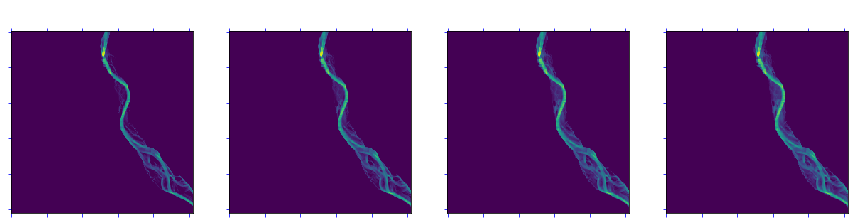

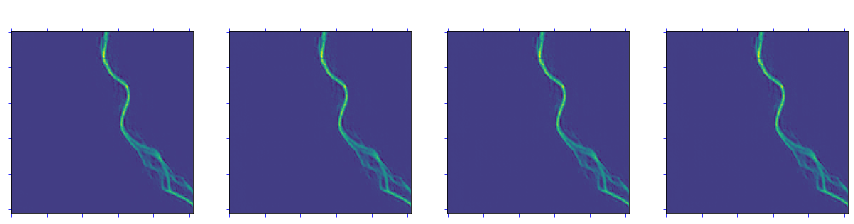

In [130]:
k = np.random.randint(len(X_train))
iterations = 4
#k = 5

input = th.unsqueeze(X_train[k,0], 0)
outputs = net(input)

#------------------------------
print("======== Past frames ========")
num_predicted_frames = outputs[0,0].shape[0] # per allineare frames passati e futuri
fig, axs = plt.subplots(1, num_predicted_frames, figsize=(plotsize,plotsize))

for ax in axs:
    ax.set_yticklabels([])
    ax.set_xticklabels([])

for i,frame in enumerate(input[0,0,-num_predicted_frames:]):
    axs[i].matshow(frame.cpu().detach().numpy())
    axs[i].set_title('t = {}'.format(i))

plt.show()
#------------------------------
print("======== True vs Autoregressive Pred Frames  ========")
fig, axs = plt.subplots(1, num_predicted_frames, figsize=(plotsize,plotsize))

for ax in axs:
    ax.set_yticklabels([])
    ax.set_xticklabels([])

for i,frame in enumerate(y_train[k,0,0]):
    axs[i].matshow(frame.cpu().detach().numpy())
    axs[i].set_title('t = {}'.format(i+num_predicted_frames))

plt.show()
#------------------------------

#i = np.random.randint(len(X_test))
input = th.unsqueeze(X_train[k][0], 0)

fig, axs = plt.subplots(1, iterations, figsize=(plotsize,plotsize))

for ax in axs:
    ax.set_yticklabels([])
    ax.set_xticklabels([])

for x in range(iterations):
    output = th.unsqueeze(net(input)[:,:,0,:,:],2)
    next_frame = th.unsqueeze(output.detach()[0], 0)
    next_frame = th.cat((next_frame, th.unsqueeze(input[:,2:,0,:,:],2)), axis=1) # aggiungi BTM
    input = th.cat((next_frame, input[:,:,1:,:]), axis=2)

    axs[x].matshow(output[0,0,0].cpu().detach().numpy())
    axs[x].set_title('t = {}'.format(x+num_predicted_frames))
    #print(np.mean(output[0,0,0].cpu().detach().numpy()))

plt.show()

In [131]:
print("{:<20s}{:<20s}{:<20s}{:<20s}{:<20s}".format("", "min", "max", "mean", "std"))
print("{:<20s}{:<20f}{:<20f}{:<20f}{:<20f}".format("prediction", th.min(outputs), th.max(outputs), th.mean(outputs), th.std(outputs)))
print("{:<20s}{:<20f}{:<20f}{:<20f}{:<20f}".format("true", th.min(y_test[0]), th.max(y_test[0]), th.mean(y_test[0]), th.std(y_test[0])))

                    min                 max                 mean                std                 
prediction          -1.026525           5.496990            0.088095            0.424080            
true                0.000000            5.945362            0.071294            0.381137            
